In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm

import timeit
import time
import math

# ./indexer
from indexer import AppendIndexer
import ALS

# Annoy
from annoy import AnnoyIndex

#SKLearn 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import average_precision_score
from sklearn.metrics import pairwise_distances

# scipy
from scipy.spatial import distance
from scipy.sparse import lil_matrix

In [6]:
class ViewMatrix:
    def __init__(self, path):
        self.path = path
        self.original = True
        self.item_indexer = AppendIndexer.load('./entekhab.ir/view_matrix/item_indexer.indexer')
        self.user_indexer = AppendIndexer.load('./entekhab.ir/view_matrix/user_indexer.indexer')
        
    def load_matrix(path):
        
        matrix = ViewMatrix(path)

        try:
            matrix.view_matrix = ViewMatrix \
                .load_sparse_lil(path)
        except:
            print('Error: loading', path)

        return matrix

    def load_sparse_lil(filename):
        loader = np.load(filename, allow_pickle=True)
        result = lil_matrix(tuple(loader["shape"]), dtype=str(loader["dtype"]))
        result.data = loader["data"]
        result.rows = loader["rows"]
        return result
    
    def make_dense(self, user_min_view, item_min_view):
        self.original = False
        while True:
            removed_rows_cnt = self.trim_users_with_few_views(user_min_view)
            removed_columns_cnt = self.trim_columns_with_few_views(item_min_view)
            if not removed_columns_cnt and not removed_rows_cnt:
                break

    def trim_users_with_few_views(self, user_min_view):
        removing_row_indices = list(np.where(self.view_matrix.getnnz(1) < user_min_view)[0])
        print('Number of users which should be deleted:', len(removing_row_indices))
        self.trim_user_indices(to_remove_indices=removing_row_indices)
        return len(removing_row_indices)

    def trim_columns_with_few_views(self, column_min_view):
        removing_column_indices = list(np.where(self.view_matrix.getnnz(0) < column_min_view)[0])
        print('Number products which should be deleted:', len(removing_column_indices))
        self.trim_column_indices(to_remove_indices=removing_column_indices)
        return len(removing_column_indices)
    
    def trim_user_indices(self, to_remove_indices):
        self.user_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_row_lil(self.view_matrix, to_remove_indices)
    
    def trim_column_indices(self, to_remove_indices):
        self.item_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_column_lil(self.view_matrix, to_remove_indices)
    
    def delete_column_lil(mat: lil_matrix, *i) -> lil_matrix:
        mat = mat.transpose()
        mat = ViewMatrix.delete_row_lil(mat, *i)
        return mat.transpose()
    
    def delete_row_lil(mat: lil_matrix, *i) -> lil_matrix:
        if not isinstance(mat, lil_matrix):
            raise ValueError("works only for LIL format -- use .tolil() first")
        mat = mat.copy()
        mat.rows = np.delete(mat.rows, i)
        mat.data = np.delete(mat.data, i)
        mat._shape = (mat.rows.shape[0], mat._shape[1])
        return mat
    def to_csr(self):
        train_data = self.view_matrix.astype(np.float64)
        train_data = train_data.tocoo()
        train_data.data = np.log10(train_data.data) + 1
        train_data = train_data.tocsr()
        return train_data

In [7]:
def CFTrain(path: str, _alpha = 15, factors = 20):
    now = time.time()
    matrix = ViewMatrix.load_matrix(path)
    print('View matrix loaded in', time.time() - now, 'seconds.')

    now = time.time()
    sparce_matrix = matrix.to_csr()
    matrix.make_dense(user_min_view = 2, 
                      item_min_view = 2)
    print('matrix has been made dense in', time.time() - now, 'seconds.')

    als_model = ALS.Als(num_factors = factors,
                        iterations = 15,
                        num_threads = 15,
                        alpha = _alpha)

    implicit_matrix = matrix.to_csr()

    print()
    now = time.time()
    als_model.fit(implicit_matrix)
    print('ALS model is fitted in', time.time() - now, 'seconds.')
    
    print('Saving Data ...')
    matrix.item_indexer.dump('./entekhab.ir/alisResult/ali_item_indexer_factorized.indexer')
    matrix.user_indexer.dump('./entekhab.ir/alisResult/ali_user_indexer_factorized.indexer')
    np.save('./entekhab.ir/alisResult/ali_items_vectors.npy', als_model.item_vectors)
    np.save('./entekhab.ir/alisResult/ali_users_vectors.npy', als_model.user_vectors)
    
    return sparce_matrix, implicit_matrix, als_model.item_vectors, als_model.user_vectors

In [58]:
def get_annoy_results(pages_vector, number_of_trees = 170, number_of_neighbours = 30):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(pages_vector.shape[1], 'angular')
    
    for index, vector in enumerate(pages_vector):
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for i in pages_vector:
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
    print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

In [29]:
sparce_matrix, implicit_matrix, item_vectors, user_vectors = \
CFTrain('./entekhab.ir/view_matrix/lil_matrix.npz', factors = 20, _alpha = 80)

View matrix loaded in 9.576667070388794 seconds.
Number of users which should be deleted: 1784866
Number products which should be deleted: 26556
Number of users which should be deleted: 2255
Number products which should be deleted: 155
Number of users which should be deleted: 77
Number products which should be deleted: 4
Number of users which should be deleted: 2
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 40.838239908218384 seconds.

ALS model is fitted in 33.00262999534607 seconds.
Saving Data ...


In [10]:
implicit_matrix = implicit_matrix.toarray()
implicit_matrix.shape

(309950, 6051)

In [11]:
popularity_count = {}
for i, j in tqdm(enumerate(implicit_matrix.T)):
    popularity_count[i] = np.greater(j, 0).sum()

6051it [01:08, 87.84it/s] 


In [12]:
site_trend = {k: v for k, v in sorted(popularity_count.items(), key=lambda item: item[1], reverse = True)}

In [13]:
len(site_trend)

6051

In [14]:
pop = []
item = []
for i, j in site_trend.items():
    pop.append(j)
    item.append(i)

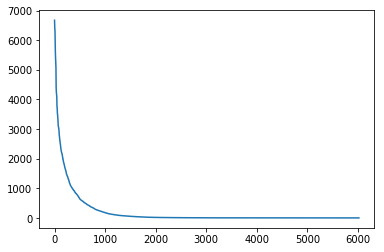

In [15]:
plt.plot(pop[30:])

In [68]:
ind, dis, d = get_annoy_results(item_vectors, number_of_neighbours = 30)
ind2 = []
for i in ind:
    ind2.append(i[1:])

annoy time: 4.093634843826294


In [69]:
ind2 = np.array(list((np.array(ind2)).flatten()))

In [70]:
res = []
for i in item:
    res.append(np.equal(ind2, i).sum())

In [71]:
def a(s):
    r = []
    for i in range(len(s)-250):
        r.append(np.array(s[i:i+250]).mean())
    return r

In [74]:
res = a(res)

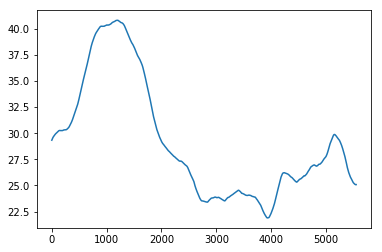

In [75]:
plt.plot(res)

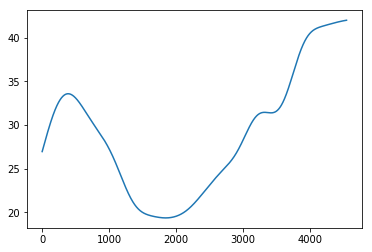

In [49]:
res = a(res)
plt.plot(res)

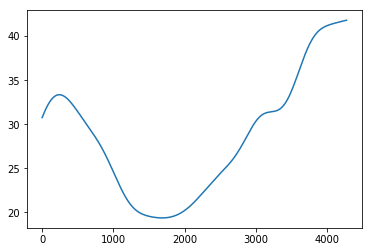

In [50]:
res = a(res)
plt.plot(res[30:])